In [7]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf  # For tf.data
import keras
from keras import layers

import matplotlib.pyplot as plt

In [23]:


# Directory containing the .npz files
input_dir = 'synthetic_datasets_for_pointnet'  # Adjust this path as needed

# Initialize the lists
point_clouds = []
all_labels = []
point_cloud_labels = []
test_point_clouds = []

for file_name in os.listdir(input_dir):
    if file_name.endswith('.npz'):
        # Load the .npz file
        file_path = os.path.join(input_dir, file_name)
        data = np.load(file_path)
        
        # Extract point cloud and labels
        point_cloud = data['points']  # Adjust key based on your file structure
        labels = data['labels']       # Adjust key based on your file structure
        
        # Transform labels: make non-zero labels equal to 1
        #labels = (labels > 0).astype(int)
        
        # Convert labels to string format for visualization
        labels_str = labels.astype(str)
        
        # Create one-hot encoded labels
        #one_hot_labels = np.eye(2)[labels]  # Assuming 2 classes: 0 and 1
        # Adjust label values to be suitable for one-hot encoding
        adjusted_labels = labels + 1  # This shifts -1 to 0, 0 to 1, and 1 to 2
        # Create one-hot encoded labels for 3 classes: -1, 0, and 1
        one_hot_labels = np.eye(3)[adjusted_labels]
        
        # Append data to the lists
        point_clouds.append(point_cloud)
        all_labels.append(labels_str)
        point_cloud_labels.append(one_hot_labels)
        
        # For test_point_clouds, assume we're only storing the point clouds
        test_point_clouds.append(point_cloud)

# Example: Accessing the first point cloud and its labels
first_point_cloud = point_clouds[0]
first_labels = all_labels[0]
first_point_cloud_labels = point_cloud_labels[0]

print("First point cloud:", first_point_cloud)
print("First labels (string):", first_labels)
print("First point cloud labels (one-hot):", first_point_cloud_labels)


First point cloud: [[-14.92813679 -10.19269312  -2.71336522]
 [ 24.66530327  16.8272686   12.80690265]
 [ 14.78914139   9.51075408  10.61209445]
 ...
 [ 44.86208993  27.87700496  18.5713743 ]
 [-22.90001208 -12.53457785  -2.54991887]
 [-49.02564227  34.68062644   1.08473819]]
First labels (string): ['0' '0' '1' ... '1' '0' '-1']
First point cloud labels (one-hot): [[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [24]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[2944].shape: (4096, 3)
point_cloud_labels[2944].shape: (4096, 3)
all_labels[2944][0]: 1 	point_cloud_labels[2944][0]: [0. 0. 1.] 

all_labels[2944][1]: -1 	point_cloud_labels[2944][1]: [1. 0. 0.] 

all_labels[2944][2]: 0 	point_cloud_labels[2944][2]: [0. 1. 0.] 

all_labels[2944][3]: 1 	point_cloud_labels[2944][3]: [0. 0. 1.] 

all_labels[2944][4]: 1 	point_cloud_labels[2944][4]: [0. 0. 1.] 

point_clouds[2129].shape: (4096, 3)
point_cloud_labels[2129].shape: (4096, 3)
all_labels[2129][0]: 1 	point_cloud_labels[2129][0]: [0. 0. 1.] 

all_labels[2129][1]: 0 	point_cloud_labels[2129][1]: [0. 1. 0.] 

all_labels[2129][2]: 0 	point_cloud_labels[2129][2]: [0. 1. 0.] 

all_labels[2129][3]: 0 	point_cloud_labels[2129][3]: [0. 1. 0.] 

all_labels[2129][4]: 0 	point_cloud_labels[2129][4]: [0. 1. 0.] 

point_clouds[4818].shape: (4096, 3)
point_cloud_labels[4818].shape: (4096, 3)
all_labels[4818][0]: 0 	point_cloud_labels[4818][0]: [0. 1. 0.] 

all_labels[4818][1]: 0 	point_cloud_lab

In [27]:
#LABELS = ['0', '1']
#COLORS=['blue', 'red']

LABELS = ['-1','0', '1']
COLORS =['black','blue', 'red']

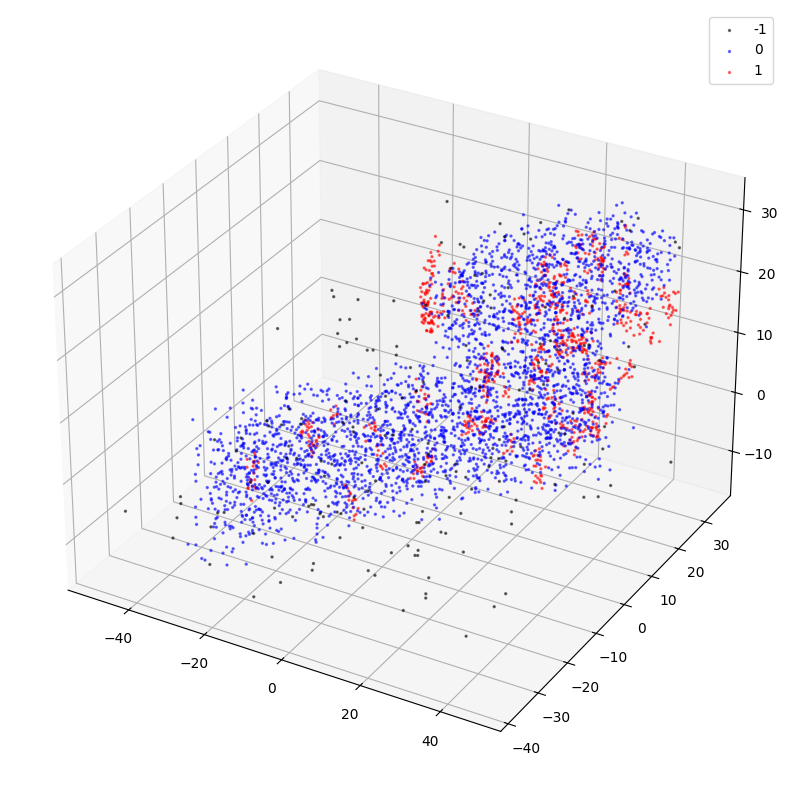

In [28]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index], s=2
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[0], all_labels[0])

In [29]:
NUM_SAMPLE_POINTS = 4096

for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 6000/6000 [00:20<00:00, 286.01it/s]


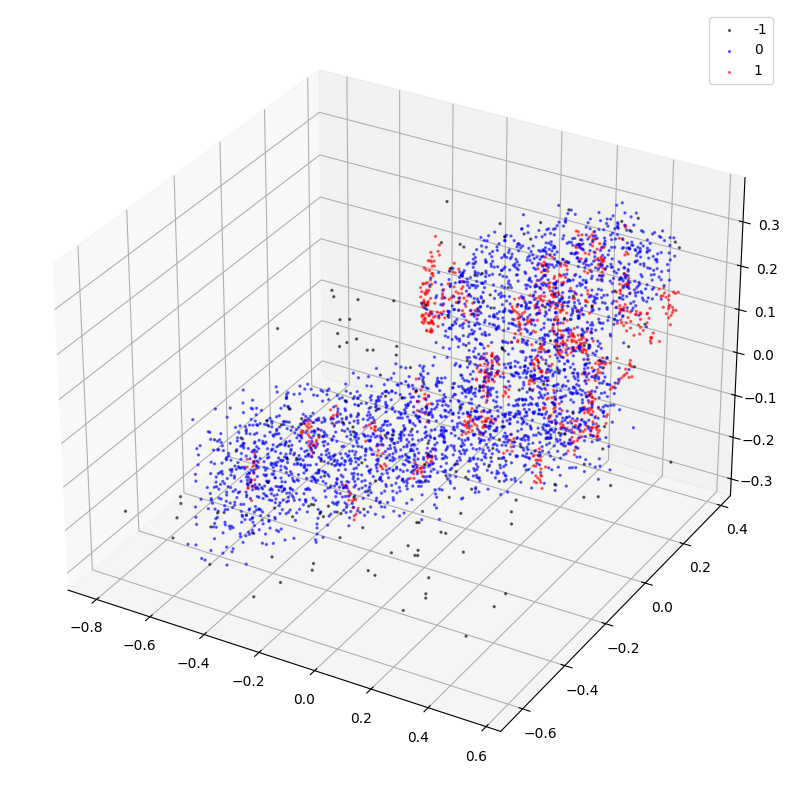

In [30]:
visualize_data(point_clouds[0], all_labels[0])

In [31]:
len(point_cloud_labels)

6000

In [32]:
VAL_SPLIT = 0.2
BATCH_SIZE = 32

In [33]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS)])
    return point_cloud_batch, label_cloud_batch

def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(point_cloud_batch), -0.001, 0.001, dtype=tf.float64
    )
    point_cloud_batch += noise
    return point_cloud_batch, label_cloud_batch

def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    if is_training:
        dataset = dataset.shuffle(BATCH_SIZE * 100)
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    if is_training:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

Num train point clouds: 4800
Num train point cloud labels: 4800
Num val point clouds: 1200
Num val point cloud labels: 1200


In [34]:
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 4096, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4096, 3), dtype=tf.float64, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 4096, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4096, 3), dtype=tf.float64, name=None))>


# Pointnet

In [35]:
def conv_block(x, filters, name):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x, filters, name):
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

In [36]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = keras.ops.eye(num_features)

    def __call__(self, x):
        x = keras.ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = keras.ops.tensordot(x, x, axes=(2, 2))
        xxt = keras.ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return keras.ops.sum(self.l2reg * keras.ops.square(xxt - self.identity))

    def get_config(self):
        config = super().get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

In [37]:
def transformation_net(inputs, num_features, name):
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs, num_features, name):
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [38]:
def get_shape_segmentation_model(num_points, num_classes):
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = keras.ops.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

## Training

In [39]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 64)  │        256 │ input_layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 64)  │        256 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 64)  │          0 │ input_transforma… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 128) │      8,320 │ input_transforma… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 128) │        512 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None, 128) │          0 │ input_transforma… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None,      │    132,096 │ input_transforma… │
│ (Conv1D)            │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None,      │      4,096 │ input_transforma… │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, None,      │          0 │ input_transforma… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ input_transforma… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 512)       │    524,800 │ global_max_pooli… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 512)       │      2,048 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 512)       │          0 │ input_transforma… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 256)       │    131,328 │ input_transforma… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 256)       │      1,024 │ input_transforma… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_transformati… │ (None, 256)       │          0 │ input_transforma

 Total params: 7,369,804 (28.11 MB)

 Trainable params: 7,355,852 (28.06 MB)

 Non-trainable params: 13,952 (54.50 KB)

In [72]:
EPOCHS = 10
INITIAL_LR = 1e-3

Steps per epoch: 150.
Total training steps: 1500.


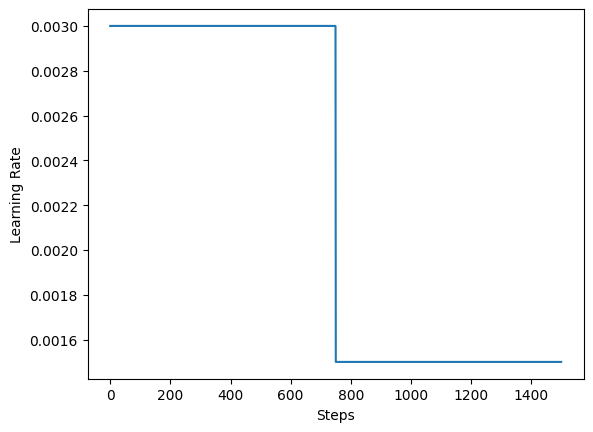

In [71]:
steps_per_epoch = total_training_examples // BATCH_SIZE
#total_training_steps = steps_per_epoch * EPOCHS
total_training_steps = steps_per_epoch * 10
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [73]:
def run_experiment(epochs):
    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1469s 10s/step - accuracy: 0.7085 - loss: 8372.3779 - val_accuracy: 0.7382 - val_loss: 1306.4386
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1466s 10s/step - accuracy: 0.7502 - loss: 146.1182 - val_accuracy: 0.7507 - val_loss: 678.7455
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1497s 10s/step - accuracy: 0.7531 - loss: 138.1418 - val_accuracy: 0.7535 - val_loss: 181.1549
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1429s 10s/step - accuracy: 0.7570 - loss: 136.0069 - val_accuracy: 0.7482 - val_loss: 133.8121
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1421s 9s/step - accuracy: 0.7583 - loss: 134.9739 - val_accuracy: 0.7543 - val_loss: 132.3963
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1454s 10s/step - accuracy: 0.7621 - loss: 134.4181 - val_accuracy: 0.7427 - val_loss: 132.0759
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1509s 10s/step - accuracy: 0.7658 - loss: 133.9860 - val_accuracy: 0.7626 - val_loss: 131.9084
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1506s 10s/step

## Results for different datasets

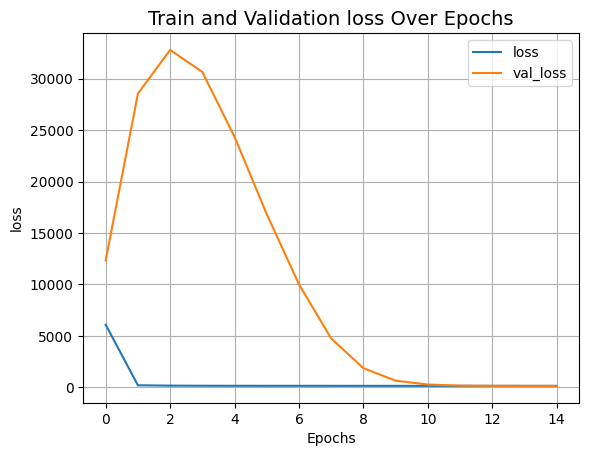

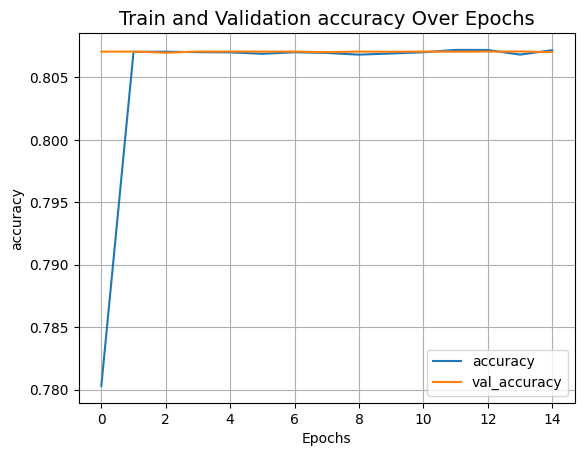

In [65]:
# Old synthetic data

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Validation prediction shape: (32, 4096, 2)
Index selected: 28


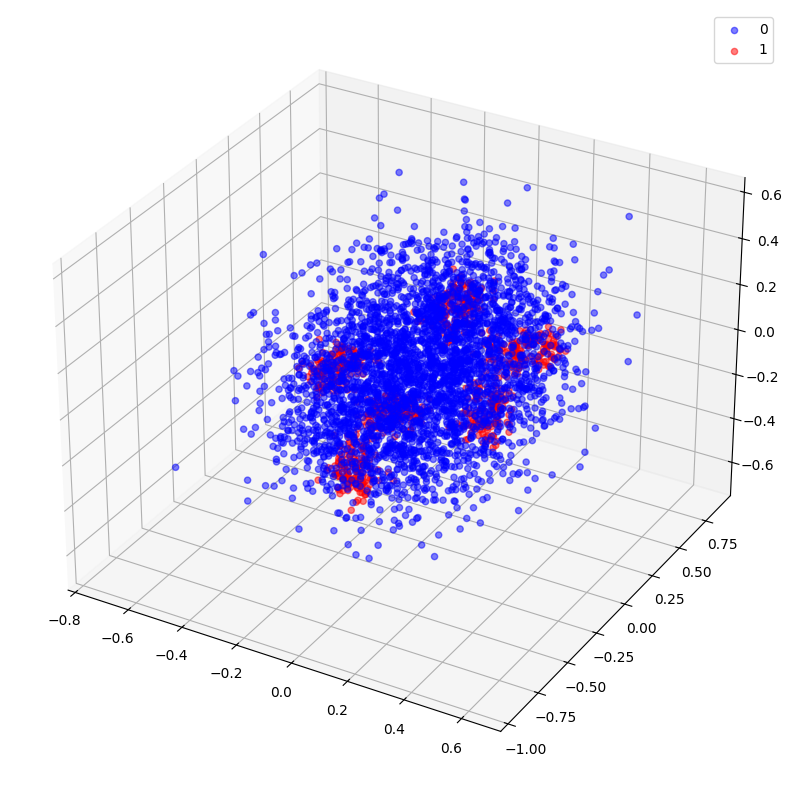

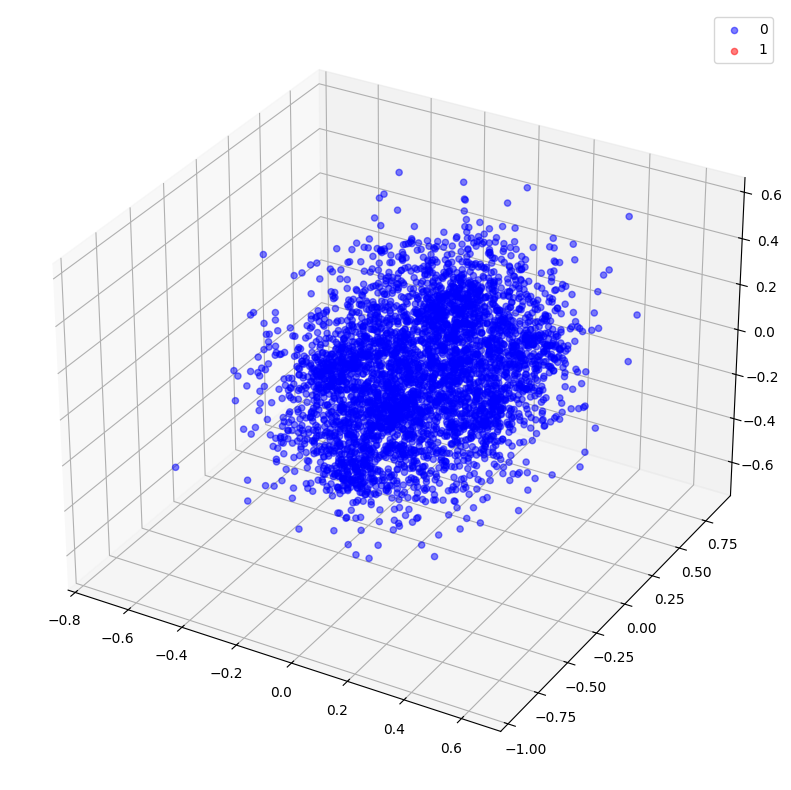

In [73]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

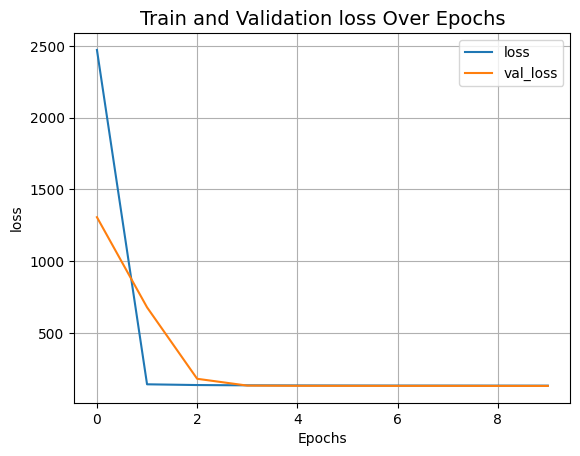

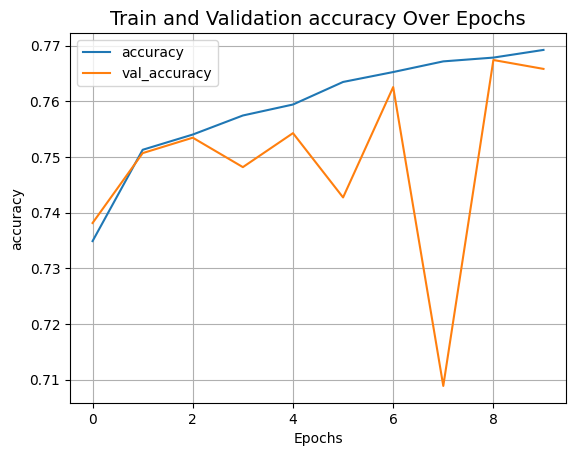

In [74]:
# new synthetic data

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Validation prediction shape: (32, 4096, 3)
Index selected: 28


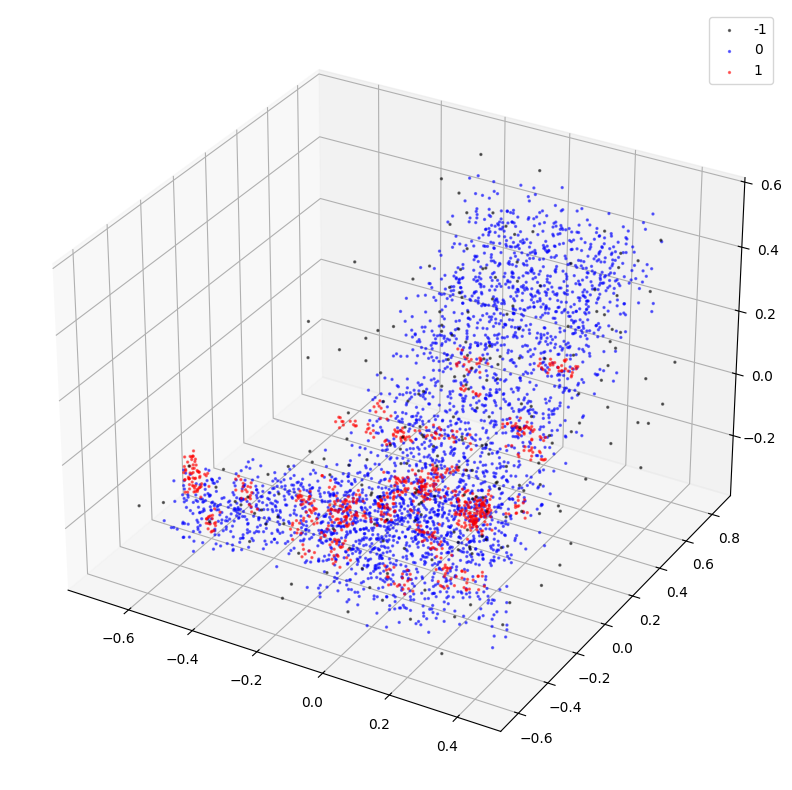

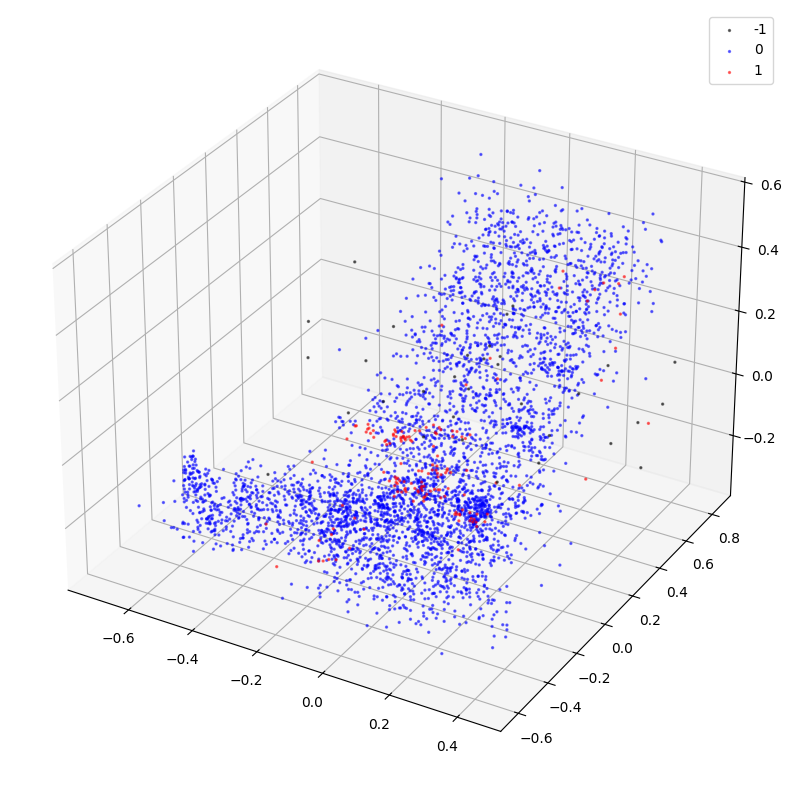

In [75]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

# test on M0

In [76]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = 'seiscomp-exp-dd_20240415.csv'
point_cloud_data = pd.read_csv(file_path)

# Assuming the CSV has columns 'x', 'y', 'z' for coordinates
point_cloud = point_cloud_data[['x', 'y', 'z']].to_numpy()

# Print the first few rows of the data for verification
print(point_cloud[:5])


[[-101.76982257  -48.98239087  -96.3144238 ]
 [ -96.96986771  -48.42162989  -89.8761922 ]
 [ -97.59722032  -50.003603    -88.4148522 ]
 [-103.39201587  -54.97899005  -89.782843  ]
 [-103.38345122  -54.93363885  -89.7649755 ]]


In [77]:
# Example normalization: center and scale the point cloud
point_cloud_mean = np.mean(point_cloud, axis=0)
point_cloud_std = np.std(point_cloud, axis=0)
normalized_point_cloud = (point_cloud - point_cloud_mean) / point_cloud_std

# Check the normalized point cloud
print(normalized_point_cloud[:5])


[[-0.5913907   0.02673994 -0.22935012]
 [-0.17668967  0.11487217  0.41306991]
 [-0.23089097 -0.13375928  0.55888543]
 [-0.73154311 -0.91571801  0.42238448]
 [-0.73080315 -0.90859037  0.42416734]]


In [78]:
NUM_SAMPLE_POINTS = 4096  # Adjust based on your model's requirements

# Pad or truncate the point cloud
if len(normalized_point_cloud) < NUM_SAMPLE_POINTS:
    # Pad with zeros
    padding = np.zeros((NUM_SAMPLE_POINTS - len(normalized_point_cloud), 3))
    test_point_cloud = np.vstack((normalized_point_cloud, padding))
else:
    # Truncate to the first NUM_SAMPLE_POINTS
    test_point_cloud = normalized_point_cloud[:NUM_SAMPLE_POINTS]

# Reshape to match model input
test_point_cloud = test_point_cloud.reshape((1, NUM_SAMPLE_POINTS, 3))


In [79]:
# Make predictions using the trained model
predictions = segmentation_model.predict(test_point_cloud)

# Print predictions
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
[[[0. 1. 0.]
  [0. 1. 0.]
  [0. 1. 0.]
  ...
  [0. 1. 0.]
  [0. 1. 0.]
  [0. 1. 0.]]]


In [80]:
# Assuming a binary classification model with output shape [1, num_points, 2]
predicted_labels = np.argmax(predictions, axis=2)

# Flatten the array to match the original point cloud shape
predicted_labels = predicted_labels.flatten()
print(predicted_labels[:10])


[1 1 1 1 1 1 1 1 1 1]


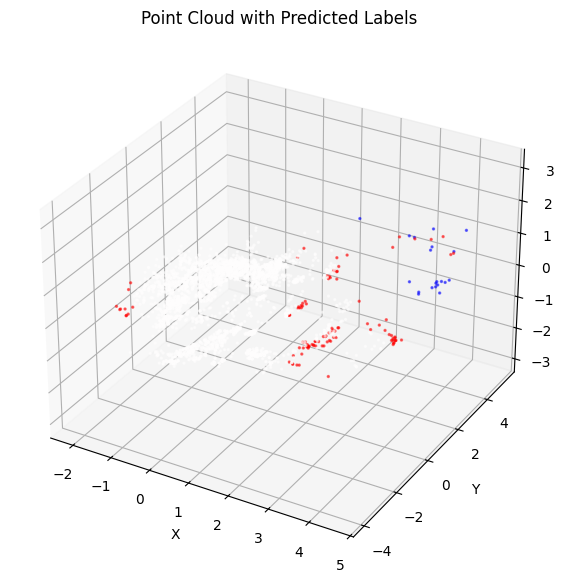

In [81]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_point_cloud_with_labels(point_cloud, labels):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assuming labels are 0 or 1, use different colors
    ax.scatter(
        point_cloud[:, 0],
        point_cloud[:, 1],
        point_cloud[:, 2],
        c=labels,
        cmap='bwr',  # Blue for 0, Red for 1
        alpha=0.5,
        s=2
    )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Point Cloud with Predicted Labels')
    plt.show()

# Visualize the point cloud with predicted labels
visualize_point_cloud_with_labels(test_point_cloud.reshape(-1, 3), predicted_labels)


## Pointnet ++

In [55]:
def farthest_point_sampling(points, num_samples):
    """
    Perform farthest point sampling on a point cloud to select a subset of points.
    points: Input point cloud of shape (B, N, 3)
    num_samples: Number of points to sample
    """
    def _initial_sample(points):
        return points[:, :1, :]

    def _sample_point(args):
        points, sampled_points = args
        dist = keras.backend.sum((points - sampled_points) ** 2, axis=-1)
        farthest_point_idx = keras.backend.argmax(dist, axis=1)
        return points[keras.backend.arange(keras.backend.shape(points)[0]), farthest_point_idx]

    # Initialize an empty tensor for sampled points
    sampled_points = layers.Lambda(_initial_sample, output_shape=(1, 3), name="initial_sampled_points")(points)

    # Iteratively select points based on farthest distance
    for i in range(1, num_samples):
        next_sampled_point = layers.Lambda(_sample_point, output_shape=(1, 3), name=f"sample_point_{i}")([points, sampled_points])
        sampled_points = layers.Concatenate(axis=1)([sampled_points, next_sampled_point])

    return sampled_points

In [61]:
def grouping_layer(points, sampled_points, k=32):
    """
    Group points around each sampled point using k-NN.
    points: Input point cloud of shape (B, N, 3)
    sampled_points: Sampled points of shape (B, M, 3)
    k: Number of neighbors to group
    """
    def _nearest_neighbor(args):
        points, sampled_points = args
        dist = keras.backend.sum((points[:, :, None, :] - sampled_points[:, None, :, :]) ** 2, axis=-1)
        indices = keras.backend.argsort(dist, axis=1)[:, :, :k]
        batch_indices = keras.backend.tile(keras.backend.arange(keras.backend.shape(points)[0])[:, None, None], (1, keras.backend.shape(sampled_points)[1], k))
        gathered_points = keras.backend.gather_nd(points, keras.backend.stack([batch_indices, indices], axis=-1))
        return gathered_points
    
    grouped_points = layers.Lambda(_nearest_neighbor, output_shape=(None, k, 3), name="grouped_points")([points, sampled_points])
    
    # Reshape to match the Conv1D expected input
    grouped_points = layers.Reshape((-1, k * 3))(grouped_points)
    
    return grouped_points

In [66]:
def set_abstraction_layer(points, features, num_samples, radius, k, filters, name):
    """
    Set abstraction layer to sample, group, and extract local features.
    points: Input point cloud of shape (B, N, 3)
    features: Input features of shape (B, N, C)
    num_samples: Number of points to sample
    radius: Radius for grouping points
    k: Number of neighbors to consider
    filters: List of filters for each conv_block
    name: Name of the layer
    """
    # Sample points
    sampled_points = farthest_point_sampling(points, num_samples)

    # Group points and extract local features
    grouped_points = grouping_layer(points, sampled_points, k=k)
    
    # Apply conv_block to each group of points
    for i, f in enumerate(filters):
        grouped_points = conv_block(grouped_points, filters=f, name=f"{name}_conv_{i}")
    
    # After applying conv_block, reduce to 3D
    grouped_points = layers.MaxPool1D(pool_size=k)(grouped_points)
    
    # Reshape the output to be compatible with MaxPool1D
    x = layers.Reshape((num_samples, filters[-1]))(grouped_points)
    
    return x

In [67]:
def feature_propagation_layer(points, sampled_points, features, interpolated_features, name):
    """
    Feature propagation layer to interpolate features from sampled points back to the original points.
    points: Original point cloud of shape (B, N, 3)
    sampled_points: Sampled point cloud of shape (B, M, 3)
    features: Features corresponding to the sampled points
    interpolated_features: Interpolated features from previous layers
    name: Name of the layer
    """
    # Interpolate features
    interpolated = layers.Lambda(lambda x: keras.backend.batch_dot(x[0], x[1]), name=f"{name}_interpolation")([sampled_points, features])
    
    # Concatenate with existing features
    return layers.Concatenate(name=f"{name}_concatenate")([interpolated, interpolated_features])

In [68]:
def get_pointnet_plus_plus_model(num_points, num_classes):
    input_points = keras.Input(shape=(None, 3))

    # Initial transformation
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )

    # First Set Abstraction Layer
    sa1 = set_abstraction_layer(
        points=transformed_inputs,
        features=transformed_inputs,
        num_samples=512,
        radius=0.1,
        k=32,
        filters=[64, 64, 128],
        name="sa1"
    )
    
    # Second Set Abstraction Layer
    sa2 = set_abstraction_layer(
        points=sa1,
        features=sa1,
        num_samples=128,
        radius=0.2,
        k=64,
        filters=[128, 128, 256],
        name="sa2"
    )
    
    # Global features
    global_features = layers.GlobalMaxPooling1D(name="global_features")(sa2)
    
    # Feature Propagation
    fp1 = feature_propagation_layer(sa1, sa2, sa2, sa1, name="fp1")
    fp2 = feature_propagation_layer(input_points, sa1, fp1, transformed_inputs, name="fp2")

    # Segmentation head
    segmentation_features = conv_block(
        fp2, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    
    return keras.Model(input_points, outputs)

In [70]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_pointnet_plus_plus_model(num_points, num_classes)
segmentation_model.summary()

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(None, 128, 256), dtype=float32, sparse=False, name=keras_tensor_4895>', '<KerasTensor shape=(None, 128, 256), dtype=float32, sparse=False, name=keras_tensor_4895>'],)
  • kwargs={'mask': ['None', 'None']}

In [69]:
def run_experiment(epochs):
    segmentation_model = get_pointnet_plus_plus_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(None, 128, 256), dtype=float32, sparse=False, name=keras_tensor_3568>', '<KerasTensor shape=(None, 128, 256), dtype=float32, sparse=False, name=keras_tensor_3568>'],)
  • kwargs={'mask': ['None', 'None']}